# Исследование объявлений о продаже квартир

Нужно научиться **определять рыночную стоимость** объектов недвижимости. **Задача:** установить эти параметры. Это позволит построить автоматизированную систему отслеживания аномалий и мошеннической деятельности. В распоряжении данные сервиса [Яндекс.Недвижимость](https://realty.ya.ru/) — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.

По каждой квартире на продажу доступны два вида данных:
- вписаны пользователем,
- получены автоматически на основе картографических данных. Например: _расстояние до центра, аэропорта, ближайшего парка и водоёма_.

В проекте присутствуют действующие ссылки, которые позволяют перемещаться между разделами проекта.

### План работы:
1. [Чтение и знакомство с исходными данными](#section_1)
2. [Предобработка данных](#section_2)
3. [Дополнение информацией](#section_3)
4. [Анализ данных. Поиск зависимостей](#section_4)
5. [Общий вывод](#section_5)
___

<a id='section_1'></a>
# 1. Откройте файл с исходными данными

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
try:
    try: #чтение csv-файла, разделитель - табуляция: '\t'
        data = pd.read_csv('datasets/real_estate_data.csv', sep='\t') #домашняя версия
    except:
        data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t' ) #сетевая версия
    display(data.head())

except:
    print('Не удалось прочесть файл. Возможно, был указан не верный путь.')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

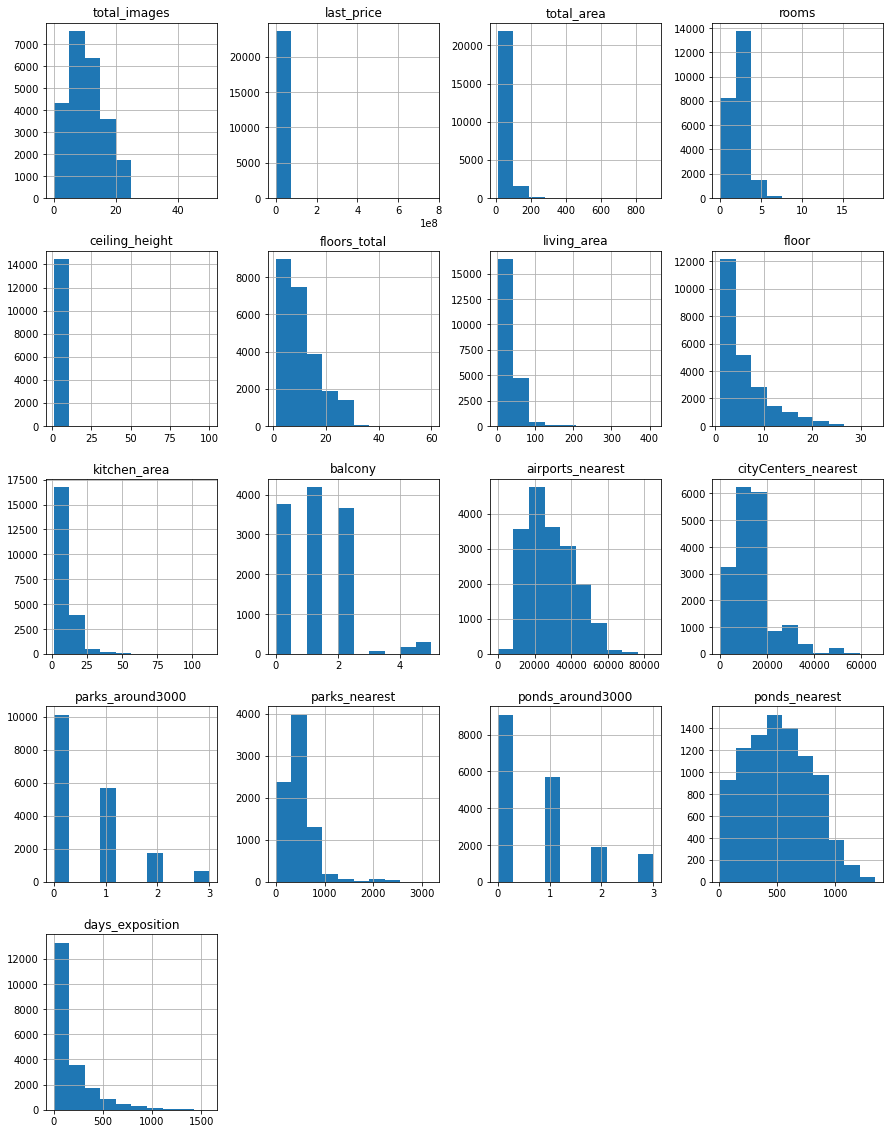

In [4]:
data.hist(figsize=(15, 20));

In [5]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 1, legend = False, fontsize = 16)
            .set_title('Доля пропусков в колонках датафрейма (значения в %)' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

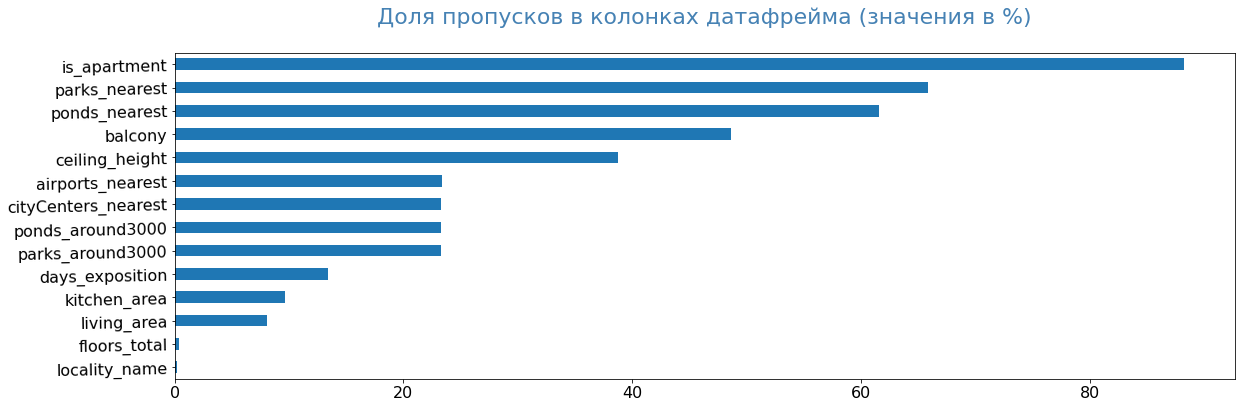

In [6]:
pass_value_barh(data)

___
<a id='section_2'></a>
# 2. Предобработка данных.

Датафрэйм содержит всего **23699** записей и 22 колонки.

Устранение **пропусков** с учётом типа данных:
- [категориальные](#section_2_1): `is_apartment`, `locality_name`.
- [количественные](#section_2_2): `ceiling_height`, `floors_total`, `living_area`, `kitchen_area`, `balcony`, `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`, `days_exposition`.

Смена [**типа данных**](#section_2_3), на тот что им соответствует:
- datetime <- `first_day_exposition`;
- int <- `floors_total`, `balcony`, `parks_around3000`, `ponds_around3000`, `days_exposition`;
- bool <- `is_apartment`.

Для колонки `cityCenters_nearest` следует перезаписать **название** в едином формате _змеиный_регистр_.

In [7]:
data = data.rename(columns={'cityCenters_nearest' : 'city_centers_nearest'}) #переименовывание столбца

<a id='section_2_1'></a>
## 2.1 Пропуски в категориальных данных

`locality_name` - **название населённого пункта**. Пропусков в этой колонке немного, всего 49 из 23699. Возможно пользователь намеренно или по ошибке не заполнил соответствующее поле, т.к. оно не является обязательным для заполнения. Пропуски будут заменены на 'no_name'.

Явные дубликаты - отсутствуют. Неявные дубликаты присутствуют. В первую очередь из-за использования буквы "ё" в названия населённых пунктов. От неё необходимо избавиться. Ничего личного.
Помимо этого, некоторые населённые пункты указаны одновременно как города, так и сёла, посёлки, деревни. Ярким примером является Мурино, который получил статус города в 2019 году. До этого момента считался посёлком. В выборке присутствуют объявления за несколько лет 2014-2019. По этой причине разные названия одного и того же населённого пункта.

Для упрощения работы с данными, я привёл названия к сокращённому варианту. Визуально это воспринимается проще. 

In [8]:
data['locality_name'] = data['locality_name'].fillna('no_name')
print("Кол-во пропусков в колонке 'locality_name':", data['locality_name'].isna().sum()) #Контроль  заполнение пропусков
print("Кол-во явных дубликатов:", data.duplicated().sum()) #Контроль явных дубликатов

items = [['ё', 'е'],
         ['садовое товарищество', 'СТ'],
         ['садоводческое некоммерческое товарищество', 'СНТ'],
         ['поселок городского типа', 'ПГТ'],
         ['коттеджный поселок', 'КП'],
         ['городской поселок', 'ГП'],
         ['поселок', 'п.'],
         ['деревня', 'дер.'],
         ['село', 'с.'],
         ['п. Мурино', 'Мурино'],
         ['п. Любань', 'Любань'],
         ['д. Кудрово', 'Кудрово'],
         ['с. Никольское', 'Никольское'],
         ['п. Рябово', 'ПГТ Рябово']]

for i in items:
    data['locality_name'] = data['locality_name'].replace(i[0], i[1], regex=True)
    
print("Кол-во населённых пунктов:", data['locality_name'].nunique())

Кол-во пропусков в колонке 'locality_name': 0
Кол-во явных дубликатов: 0
Кол-во населённых пунктов: 327


`is_apartment` - **является ли объект апартаментом** (да/нет). Пропуски составляют около 88%. Вероятней всего это связано с тем, что бóльшая часть недвижимости не являются апартаментами и пользователи просто игнорируют этот пункт. Заполню пустоты значением _False_.
Для корректной замены, сразу исправлю несоответствия между данными и их типом, заменив его на _bool_.

In [9]:
data['is_apartment'].astype('bool')
data['is_apartment'] = data['is_apartment'].fillna(False)

print(data['is_apartment'].dtypes) #Контроль
print("Кол-во пропусков в колонке 'is_apartment':", data['is_apartment'].isna().sum()) #Контроль

bool
Кол-во пропусков в колонке 'is_apartment': 0


<a id='section_2_2'></a>
## 2.2 Пропуски в количественных данных

`last_price` - **стоимость на момент снятия объявления** - пропуски отсутствуют, но необходимо избавиться от выбросов.

In [10]:
original_lengthe_df = data.shape[0]
data = data[data['last_price'] <= 40000000] #40 млн. руб.
print('Общая доля выбросов:', round((1 - data.shape[0]/original_lengthe_df)*100, 2),'%')

Общая доля выбросов: 0.77 %


`ceiling_height` - **высота потолков**. Для начала нужно избавиться от _артефактов_ типа: 25, 32, и т.п. По всей видимости в этих значениях ошиблись на один порядок. Для исправления достаточно поделить на 10, и значения будут приведены к одной ед. измерения - метрам.

В числе современных квартир появляются объекты с общей высотой потолков свыше 4 метров. Это смещает среднее арифметическое значение в бóльшую сторону. Чтобы избежать этого влияния, будет использована _медиана_ для замены пропусков.

Встречаются 2‑х этажные квартиры, или просто с высокими потолками. Для таких объектов высота обычно достигает 4 метров (исходя из списка актуальных объявлений квартир на том же самом Яндекс Недвижимость). Все значения свыше этого, будут считаться _аномалиями_ и будут удалены. То же самое касается объектов с высотой потолков ниже 2.5 метров.

Значения ДО:
mean   2.7661041217765474
median 2.65
std    1.2636013285576617

Значения ПОСЛЕ:
Общая доля выбросов: 1.04 %


count    23453.000000
mean         2.691310
std          0.199891
min          2.400000
25%          2.600000
50%          2.650000
75%          2.700000
max          4.000000
Name: ceiling_height, dtype: float64

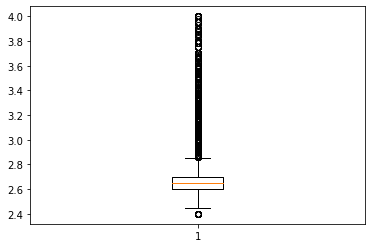

In [11]:
print('Значения ДО:')
print('mean  ', data['ceiling_height'].mean())
print('median', data['ceiling_height'].median())
print('std   ', data['ceiling_height'].std())

data.loc[data['ceiling_height']>10, 'ceiling_height'] = data.loc[data['ceiling_height']>10, 'ceiling_height']/10
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median()) #замена пропусков на медиану
data = data[data['ceiling_height']<=4.0] #удаление объектов, с аномально высокими потолками
data = data[data['ceiling_height']>=2.4] #удаление объектов, с аномально низкими потолками

print('\n' + 'Значения ПОСЛЕ:')
print('Общая доля выбросов:', round((1 - data.shape[0]/original_lengthe_df)*100, 2),'%')
plt.boxplot(data['ceiling_height'])
data['ceiling_height'].describe()

`rooms` - **количество комнат**. В выборке присутствуют единичные экземпляры квартир с 6-ю комнатами и более. При дальнейшем исследовании, они не будут учитываться, ввиду малого количества.

In [12]:
data = data[data['rooms']<=5] #удаление выбрасов
print('Общая доля выбросов:', round((1 - data.shape[0]/original_lengthe_df)*100, 2),'%')

Общая доля выбросов: 1.69 %


In [13]:
data[data['total_area'] < data['living_area'] + data['kitchen_area']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
184,7,2600000.0,30.20,2018-02-14T00:00:00,1,2.65,9.0,26.10,5,False,...,6.20,NaN,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
545,9,4700000.0,23.80,2018-12-28T00:00:00,1,2.65,18.0,20.00,9,False,...,5.00,NaN,Санкт-Петербург,9731.0,11849.0,0.0,NaN,0.0,NaN,108.0
551,8,3100000.0,31.59,2018-03-08T00:00:00,1,2.70,19.0,30.55,2,False,...,9.28,2.0,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,70.0
601,12,5600000.0,53.70,2017-04-18T00:00:00,2,2.50,12.0,48.30,5,False,...,7.00,2.0,Санкт-Петербург,50477.0,13252.0,2.0,220.0,1.0,1250.0,167.0
696,1,3364930.0,34.69,2014-11-27T00:00:00,1,2.64,25.0,23.43,25,False,...,23.43,2.0,Санкт-Петербург,43396.0,12153.0,0.0,NaN,0.0,NaN,574.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21824,20,2450000.0,44.00,2019-02-12T00:00:00,2,2.70,2.0,38.00,2,False,...,8.60,2.0,ГП Большая Ижора,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21868,12,2600000.0,34.30,2018-09-26T00:00:00,1,2.50,9.0,30.60,6,False,...,8.00,2.0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,107.0
21915,14,11990000.0,91.40,2016-05-16T00:00:00,2,2.65,16.0,62.00,12,False,...,32.40,0.0,Санкт-Петербург,10934.0,12551.0,0.0,NaN,0.0,NaN,93.0
21956,0,5200000.0,46.00,2018-07-20T00:00:00,2,2.65,5.0,44.00,5,False,...,8.00,1.0,Санкт-Петербург,14103.0,15182.0,1.0,488.0,0.0,NaN,7.0


`living_area` - **жилая площадь квартиры**. Возможно применить два метода заполнения пропусков:

**1)** Если в колонках `total_area` и `kitchen_area` присутствуют значения, то жилая площадь - разницей между площадью кухни и общей, за вычетом 18% относящиеся к нежилой площади (коридоры, ванные, кладовые, и т.п.).

**2)** В противном случае замена будет осуществляться на медиану, в зависимости от кол-ва комнат. Благо в столбце `rooms` - отсутствуют пропуски, и на их основе можно сделать справочную таблицу, со сред. площадями для каждой N-комнатной квартиры. Значение для удобства округлено до 2х знаков после запятой.

Похожую процедуру замены параллельно выполню для колонки `kitchen_area` - **площадь кухни**. Следует сделать уточнение для квартир типа: студия. У них отсутствует разделение между жилой площадью и кухней. По этой причине, площадь кухни в студиях будет принята за _ноль_.

В выборке встречаются объекты, общая площадь которых многократно превышает жилую площадь. Это свойственно для _частных домов_ или _таунхаусов_ с большим количеством хоз. помещений (котельная, электрощитовая, гараж и т.п.). Для исследования - они лишние, т.к. в выборке должны содержаться квартиры, о чём говориться в описании исходных данных. Помимо них будут отброшены малочисленные объекты, особо выделяющиеся из общей массы - _выбросы_.



In [14]:
# 1ый способ устранения пропусков
data.loc[data['rooms']==0, 'kitchen_area'] = data['kitchen_area'].fillna(0) #площадь кухни в квартира-студиях
data.loc[(data['living_area'].isna()) & (~data['kitchen_area'].isna()), 'living_area'] = (
                                                                                0.82*data['total_area'] - data['kitchen_area'])
data.loc[(data['kitchen_area'].isna()) & (~data['living_area'].isna()), 'kitchen_area'] = (
                                                                                0.82*data['total_area'] - data['living_area'])
data.loc[data['kitchen_area'] < 5, 'kitchen_area'] = 0

In [15]:
# 2ой способ устронения пропусков
rooms_type = sorted(data['rooms'].unique()) #список N-комнатных квартир
living_area_mean = list(round(data.groupby('rooms')['living_area'].median(), 2)) #список медиан жилых площадей
kitchen_area_mean = list(round(data.groupby('rooms')['kitchen_area'].median(), 2)) #список медиан площадей кухонь

info = [] #объявление и заполнение массива данных для справочной таблицы
for i in range(len(rooms_type)):
    info.append([rooms_type[i], living_area_mean[i], kitchen_area_mean[i]])
table_area = pd.DataFrame(data=info, columns=['rooms', 'living_area_mean', 'kitchen_area_mean']) #справочная таблица

for room in rooms_type: #цикл замены пропусков
    data.loc[data['rooms']==room,'living_area'] = (data.loc[data['rooms']==room, 'living_area']
                                                .fillna(float(table_area.loc[table_area['rooms']==room, 'living_area_mean'])))
    data.loc[data['rooms']==room,'kitchen_area'] = (data.loc[data['rooms']==room, 'kitchen_area']
                                                .fillna(float(table_area.loc[table_area['rooms']==room, 'kitchen_area_mean'])))

In [16]:
# вычетание нежилой площади из завышенной жилой площадии площади кухни
anomaly_area = data.loc[data['total_area'] < data['living_area']+data['kitchen_area'],
                        ['total_area', 'living_area', 'kitchen_area']]
anomaly_area['living_area'] -= anomaly_area['total_area']*0.24
anomaly_area['kitchen_area'] -= anomaly_area['total_area']*0.12
data.loc[data['total_area'] < data['living_area']+data['kitchen_area'], 'living_area'] = anomaly_area['living_area']
data.loc[data['total_area'] < data['living_area']+data['kitchen_area'], 'kitchen_area'] = anomaly_area['kitchen_area']
    
# удаление выбросов
data = data[data['total_area']<=200]
data = data[(10<=data['living_area']) & (data['living_area']<=170)]
data = data[((5<=data['kitchen_area']) & (data['kitchen_area']<=40)) | (data['kitchen_area']==0)]
data = data[data['total_area'] > data['living_area']+data['kitchen_area']]
print('Общая доля выбросов:', round((1 - data.shape[0]/original_lengthe_df)*100, 2),'%')

print("Кол-во пропусков в колонке 'living_area':", data['living_area'].isna().sum()) #Контроль
print("Кол-во пропусков в колонке 'kitchen_area':", data['kitchen_area'].isna().sum())

Общая доля выбросов: 2.81 %
Кол-во пропусков в колонке 'living_area': 0
Кол-во пропусков в колонке 'kitchen_area': 0


`balcony` - **количество балконов**. Наличие пропусков вероятней всего говорит об отсутствие балкона. По этому замена будет производится на 0.

In [17]:
data['balcony'] = data['balcony'].fillna(0)
print("Кол-во пропусков в колонке 'balcony':", data['balcony'].isna().sum()) #Контроль

Кол-во пропусков в колонке 'balcony': 0


`parks_around3000` — **число парков в радиусе 3 км**. Логично предположить, если в `parks_nearest` указано расстояние до ближайшего парка, и оно меньше 3000 метров, то как минимум одни парк поблизости присутствует и пропуск можно заменить на 1.
Но таковых объектов не оказалось. Проверка показала, что если указано расстояние до парка, то указано и их количество.
В таком случае замена будет производиться на 0, т.к. не получается найти подтверждения наличия парков поблизости.

`ponds_around3000` — **число водоёмов в радиусе 3 км**. Процедура замены - аналогична.

`parks_nearest` и `ponds_nearest` — **расстояние до ближайшего парка** и **водоёма**, соответственно. Замена на любое, ненулевое значение не имеет смысла, т.к. это исказит исходные данные.

In [18]:
# Проверка вышеописанного предположения
display(data.loc[(~data['parks_nearest'].isna()) & (data['parks_around3000'].isna())])
display(data.loc[(~data['ponds_nearest'].isna()) & (data['ponds_around3000'].isna())])

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [19]:
data.loc[data['parks_nearest'].isna(),'parks_around3000'] = data.loc[data['parks_nearest'].isna(),'parks_around3000'].fillna(0)
data['parks_nearest'] = data['parks_nearest'].fillna(0)

data.loc[data['ponds_nearest'].isna(),'ponds_around3000'] = data.loc[data['ponds_nearest'].isna(),'ponds_around3000'].fillna(0)
data['ponds_nearest'] = data['ponds_nearest'].fillna(0)

print("Кол-во пропусков в колонке 'parks_around3000':", data['parks_around3000'].isna().sum()) #Контроль
print("Кол-во пропусков в колонке 'parks_nearest':", data['parks_nearest'].isna().sum()) 
print("Кол-во пропусков в колонке 'ponds_around3000':", data['ponds_around3000'].isna().sum())
print("Кол-во пропусков в колонке 'ponds_nearest':", data['ponds_nearest'].isna().sum())

Кол-во пропусков в колонке 'parks_around3000': 0
Кол-во пропусков в колонке 'parks_nearest': 0
Кол-во пропусков в колонке 'ponds_around3000': 0
Кол-во пропусков в колонке 'ponds_nearest': 0


`airports_nearest` — **расстояние до ближайшего аэропорта**. Вероятней всего данный в этой графе отсутствуют, потому как объект недвижимости находится в населённом пункте, в котором нет аэропорта, либо расстояние до него слишком велико, чтобы это имело значение. В связи с этим пропуски будут заменены на 0, т.к. в действительности не может быть такого, чтобы квартира находилась строго на территории аэропорта. В эту же группу попала квартира, у которой изначально было указано расстояние 0 метров. В дальнейшем исследовании эти объекты будут игнорироваться с помощью указания диапазона значений.

In [20]:
data['airports_nearest'] = data['airports_nearest'].fillna(0)
print("Кол-во пропусков в колонке 'airports_nearest':", data['airports_nearest'].isna().sum()) #Контроль

Кол-во пропусков в колонке 'airports_nearest': 0


`floors_total` — **общее кол-во этажей**. Замена будет недостоверна и исказит исходные данные. Но благо таких квартир не много (86 шт.), от них можно избавиться.

In [21]:
data = data[~data['floors_total'].isna()]
data = data[data['floors_total'] <= 37]
print('Общая доля выбросов:', round((1 - data.shape[0]/original_lengthe_df)*100, 2),'%')

Общая доля выбросов: 3.18 %


`days_exposition` - **количество дней размещения объявления**. Это значение вычисляется разницей между первым и последним днём публикации объявления. Пропуски можно устранить если в распоряжении были даты завершения публикации, помимо `first_day_exposition`. По этой причине, избавлюсь только от аномалий, удалив квартиры со сроком продажи более 800 дней. В этом  случае, будет отброшено небольшой процент данных.

In [22]:
data = data[(data['days_exposition'] < 800) | (data['days_exposition'].isna())]
print('Общая доля выбросов:', round((1 - data.shape[0]/original_lengthe_df)*100, 2),'%')

Общая доля выбросов: 5.53 %


`city_centers_nearest` - **расстояние до центра города** (замена исказит исходные данные).

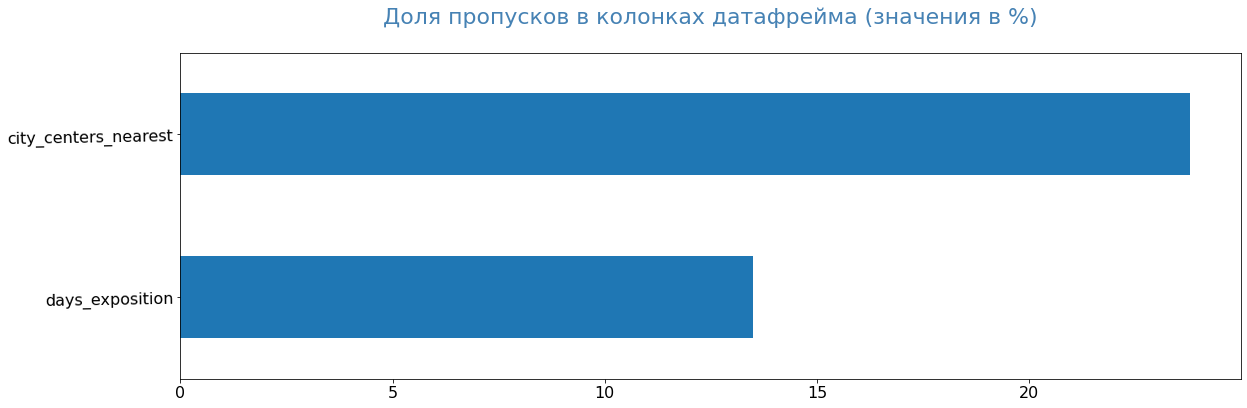

In [23]:
pass_value_barh(data) #Итоговый контроль

<a id='section_2_3'></a>
## 2.3 Изменение типов данных

Сменить **тип**, исходя из содержания данных, на более соответствующий:
- `first_day_exposition` - содержит дату публикации объявления, чему соответствует тип `datetime`. После смены типа данных в колонке будет отображаться только дата, т.к. время везде имеет одинаковое и нулевое значение;
- `last_price`, `floors_total`, `balcony`, `parks_around3000`, `ponds_around3000` - эти колонки содержат только целочисленные значения. Может быть только целое количество балконов. Только целое кол-во парков и т.д. Это соответствует типу `int`;

In [24]:
data['first_day_exposition'] =  pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

for column in ['last_price', 'floors_total', 'balcony', 'parks_around3000', 'ponds_around3000']:
    data[column] = data[column].astype('int')

data.info() #Контроль типов данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22388 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22388 non-null  int64         
 1   last_price            22388 non-null  int32         
 2   total_area            22388 non-null  float64       
 3   first_day_exposition  22388 non-null  datetime64[ns]
 4   rooms                 22388 non-null  int64         
 5   ceiling_height        22388 non-null  float64       
 6   floors_total          22388 non-null  int32         
 7   living_area           22388 non-null  float64       
 8   floor                 22388 non-null  int64         
 9   is_apartment          22388 non-null  bool          
 10  studio                22388 non-null  bool          
 11  open_plan             22388 non-null  bool          
 12  kitchen_area          22388 non-null  float64       
 13  balcony         

___
<a id='section_3'></a> 
# 3. Дополнение информации

В этом разделе будут добавлены новые столбцы со следующими параметрами:
- цена одного квадратного метра;
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «первый», «последний», «другой»);
- расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

После добавления новых столбцов, они будут перегруппированы: расположены в порядке убывания значимости и группируя по смыслу.

In [25]:
# стоимость кв. метра
data['price_meter'] = data['last_price']/data['total_area']
data['price_meter'] = data['price_meter'].astype('int') #округление до рублей, копейки - лишние.

In [26]:
# день недели, месяц, год.
data['day_week_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year

In [27]:
# тип этажа квартиры
data.loc[data['floor']==1,'floor_type'] = 'первый'
data.loc[data['floor']==data['floors_total'],'floor_type'] = 'последний'
data.loc[(data['floor']!=1) & (data['floor']!=data['floors_total']),'floor_type'] = 'другой'

In [28]:
# расстояние до центра в км.
data['city_centers_nearest_km'] = (data['city_centers_nearest']/1000).round()

In [29]:
# перегруппировка
data = data.reindex(columns=['locality_name', 'rooms', 'last_price', 'price_meter', 'total_area', 'living_area', 'kitchen_area',
                             'balcony', 'ceiling_height', 'floors_total', 'floor', 'floor_type', 'is_apartment', 'studio',
                             'open_plan', 'total_images', 'airports_nearest', 'city_centers_nearest', 'city_centers_nearest_km',
                             'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest',
                             'days_exposition', 'first_day_exposition',
                             'day_week_exposition', 'month_exposition', 'year_exposition'])
display(data.head()) #Контроль

,locality_name,rooms,last_price,price_meter,total_area,living_area,kitchen_area,balcony,ceiling_height,floors_total,...,city_centers_nearest_km,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,first_day_exposition,day_week_exposition,month_exposition,year_exposition
0,Санкт-Петербург,3,13000000,120370,108.0,51.0,25.0,0,2.70,16,...,16.0,1,482.0,2,755.0,NaN,2019-03-07,3,3,2019
1,п. Шушары,1,3350000,82920,40.4,18.6,11.0,2,2.65,11,...,19.0,0,0.0,0,0.0,81.0,2018-12-04,1,12,2018
2,Санкт-Петербург,2,5196000,92785,56.0,34.3,8.3,0,2.65,5,...,14.0,1,90.0,2,574.0,558.0,2015-08-20,3,8,2015
5,ГП Янино-1,1,2890000,95065,30.4,14.4,9.1,0,2.65,12,...,NaN,0,0.0,0,0.0,55.0,2018-09-10,0,9,2018
6,п. Парголово,1,3700000,99195,37.3,10.6,14.4,1,2.65,26,...,19.0,0,0.0,0,0.0,155.0,2017-11-02,3,11,2017


___
<a id='section_4'></a> 
# 4. Исследовательский анализ данных

## 4.1. Изучение предобработанных данных

Необходимо построить отдельные гистограммы для каждого из следующих параметров:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- день недели и месяц публикации объявления.

**Площадь (общая, жилая, и кухни).** Результат напоминает распределение _Пуассона_, с некоторыми особенностями, а именно: в диапазоне около нулевых значений площади - крайней мало объектов. После, идёт очень резкий рост до самой популярной площади, по преодолению которого следует плавный спад.

На всех гистограммах просматривается неравномерность распределения: превышение, занижение некоторых значений. Легко заменить пиковые значения площадей кухни и жилого пространства. Это связано с огромных количеством _типовых строений_: хрущевка, сталинка, брежневка. Размеры квартир и внутренних помещений были _стандартизированы_. Такие дома строились в огромном количестве по всей стране, в том числе на территории Ленинградской области. Помимо этого на внешний вид распределения повлияли _пропуски в исходных данных_. Такой вывод я могу сделать проведя аналогию с колонкой "Общая площадь", пропуски в которой - отсутствуют.

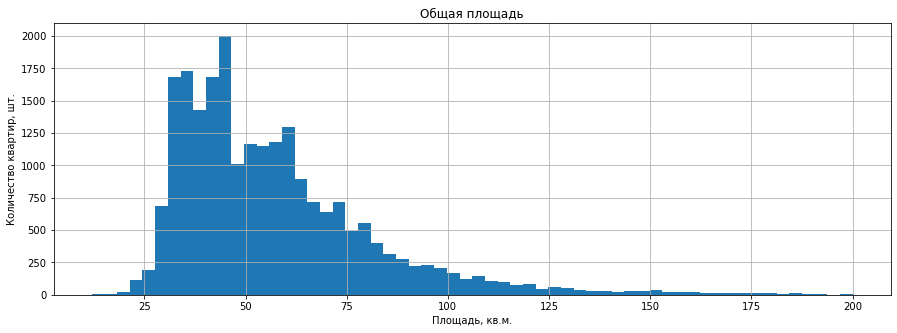

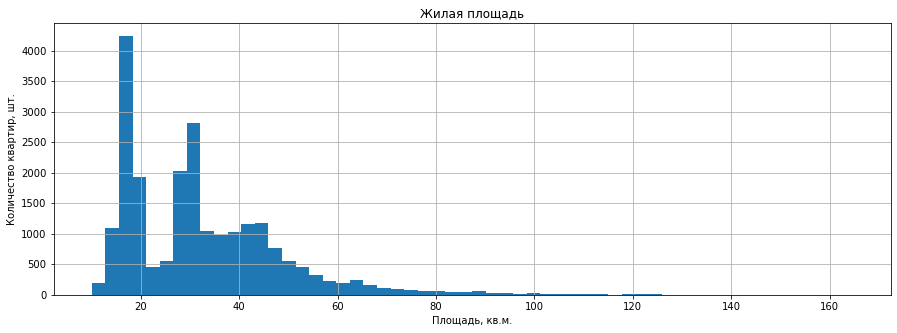

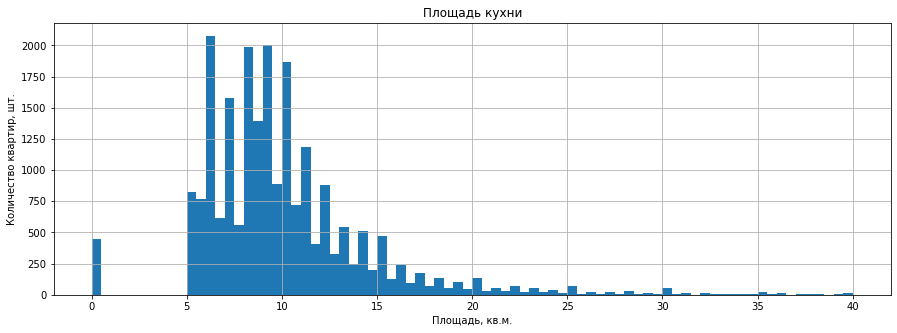

In [30]:
data['total_area'].plot(kind='hist', bins=60, figsize=(15,5), grid=True, title='Общая площадь')
plt.ylabel('Количество квартир, шт.')
plt.xlabel('Площадь, кв.м.')
plt.show()

data['living_area'].plot(kind='hist', bins=56, figsize=(15,5), grid=True, title='Жилая площадь')
plt.ylabel('Количество квартир, шт.')
plt.xlabel('Площадь, кв.м.')
plt.show()

data['kitchen_area'].plot(kind='hist', bins=80, figsize=(15,5), grid=True, title='Площадь кухни')
plt.ylabel('Количество квартир, шт.')
plt.xlabel('Площадь, кв.м.')
plt.show()

Гистограмма **стоимостей объектов**, напоминает нормальное распределение с длинным "хвостом" справа. Это связано с тем, что в Санкт-Петербурге встречаются исключительные объекты с особой исторической ценностью. Ярко выраженны максимум и симметричность.

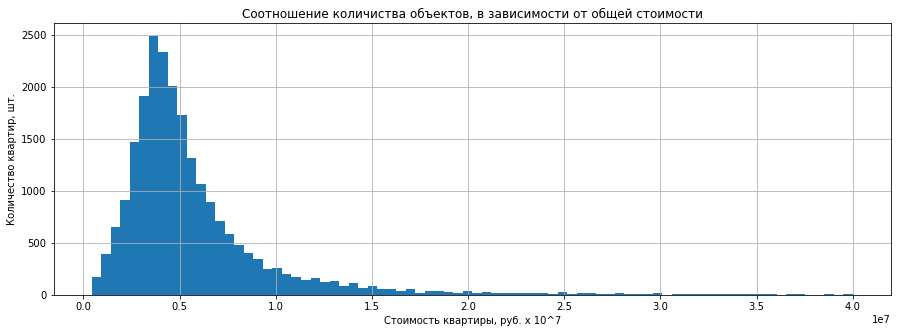

In [31]:
data['last_price'].plot(kind='hist', bins=80, figsize=(15,5), grid=True)
plt.title('Соотношение количиства объектов, в зависимости от общей стоимости')
plt.xlabel('Стоимость квартиры, руб. х 10^7')
plt.ylabel('Количество квартир, шт.');

Гистограмма **кол-ва комнат** демонстрирует большой объём предложений о продаже 1-а, 2-х, 3-х комнатных квартир. Значительно меньше этот показатель у 4х и 5ти комнатных квартир. И минимальное кол-во 6ти комнатных квартир и студий.

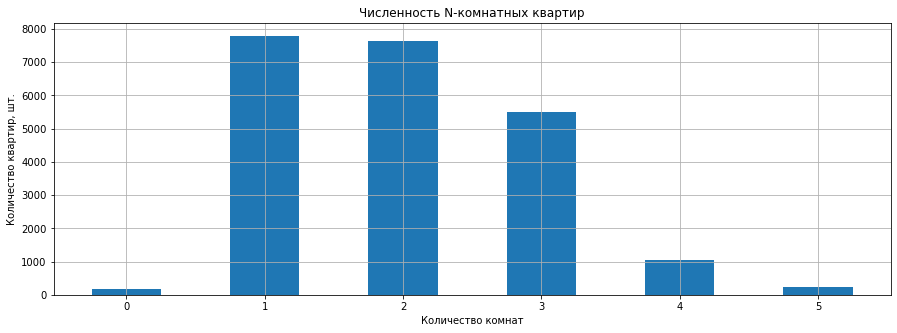

In [32]:
data['rooms'].plot(kind='hist', bins=11, figsize=(15,5), range=(-0.25, 5.25), grid=True)
plt.title('Численность N-комнатных квартир')
plt.ylabel('Количество квартир, шт.')
plt.xlabel('Количество комнат');

Среди **высот потолков** особо выделяются три значения:
- 2.50м - минимально допустимая высота для жилых помещений согласно СНиП (Строительные нормы и правила),
- 2.65м - "современный" стандарт новых квартир,
- 3.00м - новостройки повышенного класса комфорта.

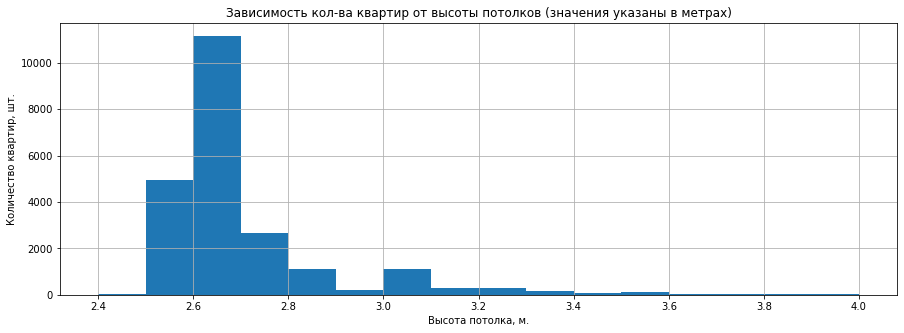

In [33]:
data['ceiling_height'].plot(kind='hist', bins=16, figsize=(15,5), grid=True)
plt.title('Зависимость кол-ва квартир от высоты потолков (значения указаны в метрах)')
plt.ylabel('Количество квартир, шт.')
plt.xlabel('Высота потолка, м.');

**Этажи.** Гистограмма расположения квартир по этажам имеет вид _распределения Пуассона_, с пиковым значение: 2ой этаж. Количество "первых" и "последний" этажей - примерно одинаково, и каждый ориентировочно составляют 13% от общего числа квартир. Среди _этажности_ домов особо распространены: 5-ти и 9-ти "этажки" массовой застройки советского периода. В меньшей степени: 11, 13, 17, 26.

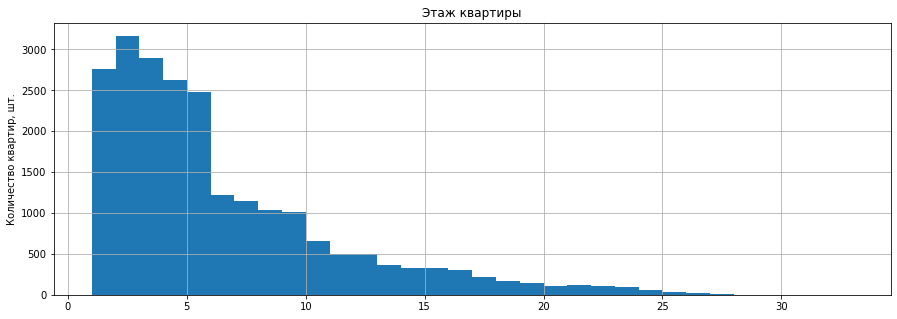

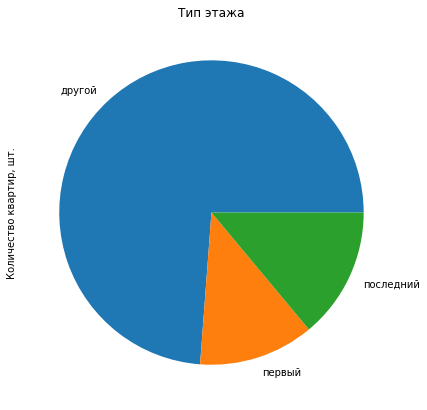

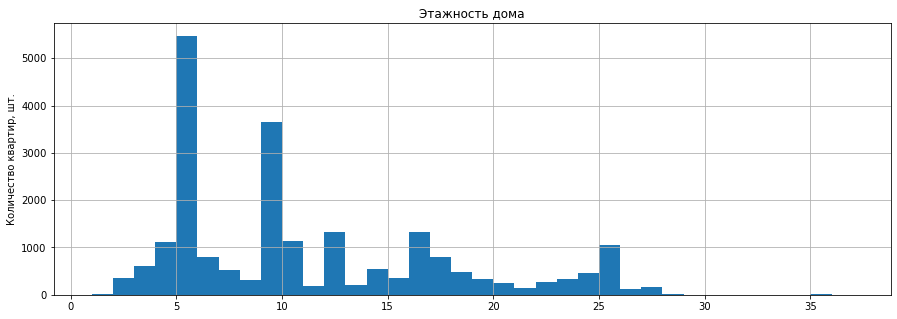

In [34]:
data['floor'].plot(kind='hist', bins=32, range=(1, 33), figsize=(15,5), grid=True, title='Этаж квартиры')
plt.ylabel('Количество квартир, шт.')
plt.show()

data.groupby('floor_type')['floor_type'].count().plot(kind='pie', figsize=(7,7), title='Тип этажа')
plt.ylabel('Количество квартир, шт.')
plt.show()

data['floors_total'].plot(kind='hist', bins=36, range=(1, 37), figsize=(15,5), grid=True, title='Этажность дома')
plt.ylabel('Количество квартир, шт.')
plt.show()

**Инфраструктура.** Рядом расположенные объекты: центр города, аэропорты, парки.

Под "центром города" в большинстве случаев подразумевается центр областного города - Санкт-Петербрга. На гистограмме отображающая _расстояние до центра города_ просматривается четыре фигуры нормального распределения, с небольшим перекрытием:
1) 1 - 10000 метров. Первый диапазон заполнен квартирами, расположенные в самом городе. Городская территория имеет около круглую границу, радиус которой около 13-15км. За пределами этой границы уже располагается территория области или другой населённый пункт. И в среднем расстояние до центра составляет 5 км.

2) 5 - 20км. Второй диапазон занимают квартиры городов-спутников СПБ. Около границы КАДа (кольцевая автодорога) - огромное количество предложений о продаже квартир. Большинство из них располагается в 12-16км. от центра Петербурга. Очевидно как город "растёт" в ширь.

3) 30±5 км. Ряд крупных городов: Кронштадт, Красное Село, Сестрорецк, и др.

4) 40±3 км. Гатчина, Ульяновка, Шлиссельбург и др.

5) 50±5 км. Рощино, Тосно, и большое количество малонаселённых поселений.

*Диапазон значений, отображаемый на гистограмме, начинается с 1 по причине того, что у ряда квартир пропуски в данных заменены на ноль.

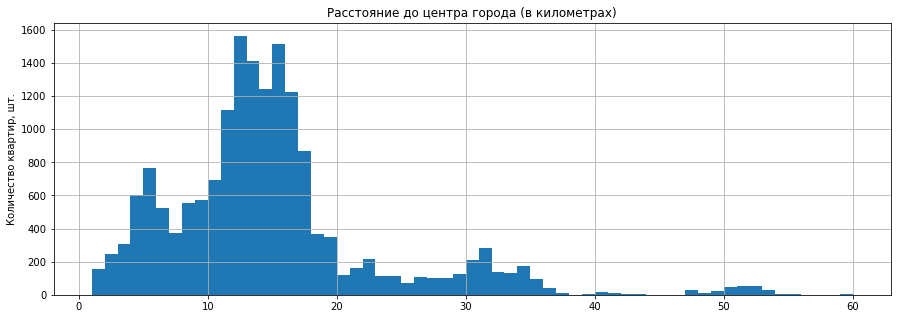

In [35]:
data['city_centers_nearest_km'].plot(kind='hist', bins=59, range=(1, 60), figsize=(15,5), grid=True)
plt.title('Расстояние до центра города (в километрах)')
plt.ylabel('Количество квартир, шт.');

В контексте **расстояния до аэропорта**, квартиры распределены достаточно хаотично. Большая часть значений находятся в диапазоне от 10 до 60 км. За редким исключением 6-9 км. Квартиры ближе 5 км. от аэропорта - не встречается.

Если рядом с квартирой **поблизости находится парк**, то расстояние до него в среднем около 500 метров, но не больше 1 километра.

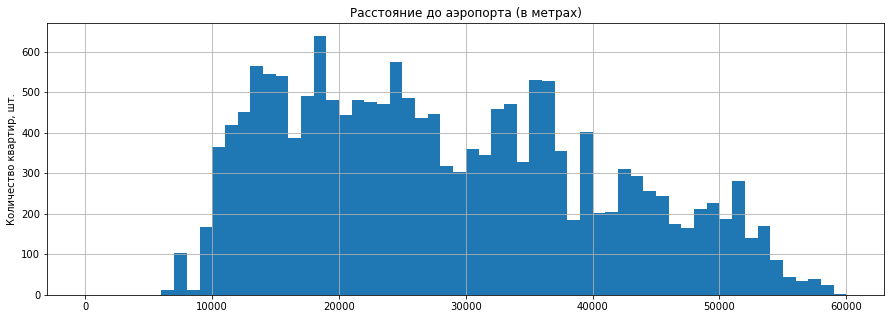

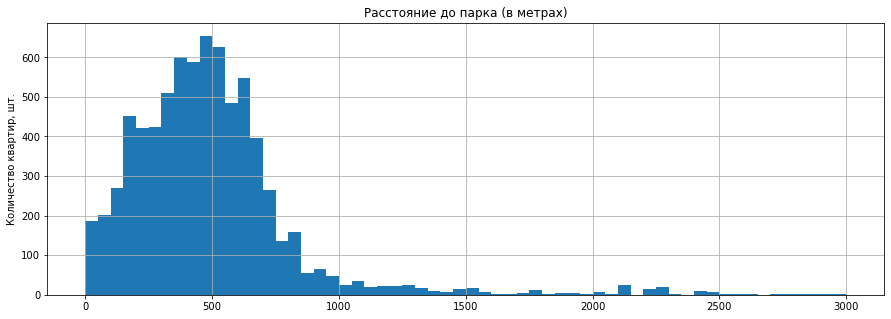

In [36]:
data['airports_nearest'].plot(kind='hist', bins=60, range=(1, 60000), figsize=(15,5), grid=True)
plt.title('Расстояние до аэропорта (в метрах)')
plt.ylabel('Количество квартир, шт.')
plt.show()

data['parks_nearest'].plot(kind='hist', bins=60, range=(1, 3000), figsize=(15,5), grid=True)
plt.title('Расстояние до парка (в метрах)')
plt.ylabel('Количество квартир, шт.')
plt.show()

**Дата публикаций.**

Наибольшая интенсивность публикаций приходится на рабочие _дни недели_, между которыми есть небольшие отличия: Вторник, четверг - максимум. Среда, пятница - средняя интенсивность. Понедельник - минимальная. _Выходные_ я намеренно выделяю из всей недели, т.к. в эти дни публикуют в 2 раза меньше. Так же просматривается _эффект инерции_: в понедельник не все успевают активизироваться с началом рабочей недели. Аналогичная ситуация в субботу, некоторые пытаются закончить дела уходящей недели.

Лидеры среди _месяцев_: февраль, март, апрель. Далее май - самый непродуктивный месяц. Вероятней всего это связано с началом периода отпусков и дачного сезона. За этим месяцем следует равномерный рост вплоть до ноября, в который кол-во публикация достигают максимальных значений. Декабрь и январь - период "застоя", связанный с предпраздничной подготовкой до НГ, и почти пол месяцы выходных после.

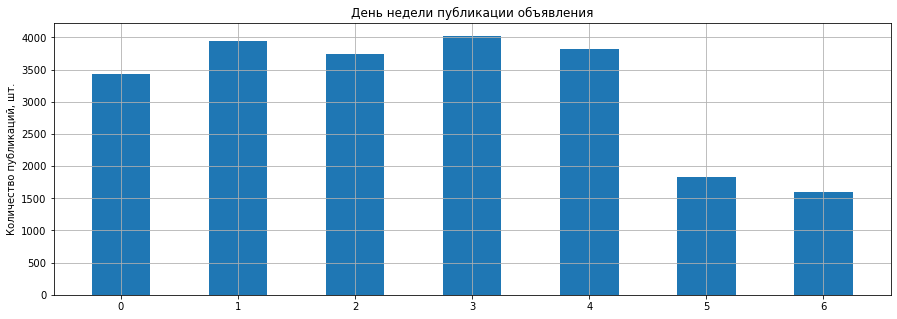

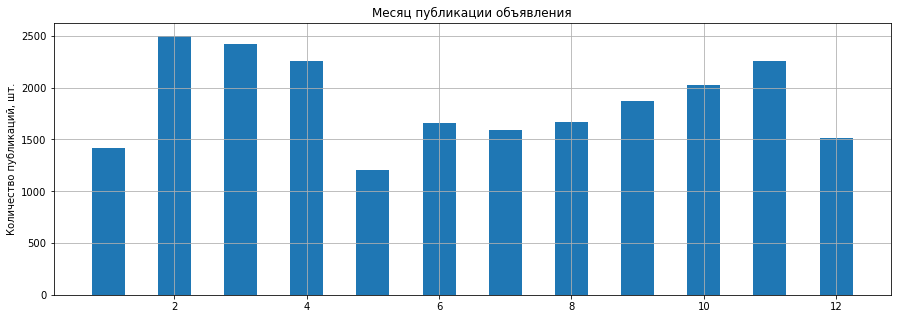

In [37]:
data['day_week_exposition'].plot(kind='hist', bins=13, range=(-0.25, 6.25), figsize=(15,5), grid=True)
plt.title('День недели публикации объявления')
plt.ylabel('Количество публикаций, шт.')
plt.show()


data['month_exposition'].plot(kind='hist', bins=23, range=(0.75, 12.25), figsize=(15,5), grid=True)
plt.title('Месяц публикации объявления')
plt.ylabel('Количество публикаций, шт.')
plt.show()

## 
## 4.2. Исследовательские задачи

### Задание №1

Изучите, как быстро продавались квартиры (столбец `days_exposition`). Этот параметр показывает, сколько дней «висело» каждое объявление.
- Постройте гистограмму.
- Посчитайте среднее и медиану.
- В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"

В среднем, квартиры продаётся за полгода, но т.к. диапазон значений сильно растянут и в редких случаях период продажи до 4х лет, нельзя полагаться на _среднее арифметическое_. Более соответствует действительности _медиана_: 95 дней. Продажи длящиеся больше этого значения можно считать "вялотекущими". А по прошествию рубежа в 180 дней - необычно долгими.

Если рассматривать весь диапазон значений, то можно заменить экспоненциальное распределение. Но большая часть продаж содержится в промежутке до 100 дней. Он отображен на втором графике. Первые 3 дня практически никто не продаёт квартиру - это минимальное время, которое необходимо для принятия решения. Особо выделяются 45-ой и 60-ый дни - с чем это связано сказать трудно, но это точно не случайность, а конкретное действие с жесткой зависимостью от времени. У меня есть предположение: по прошествию 45 суток после первичной публикации (или 60 суток после повторной публикации), квартира автоматически снимается с продаж и считается условно проданной. Если пользователь не проявит активность и не продлит публикацию объявления.

count    19370.000000
mean       154.776871
std        164.033333
min          1.000000
25%         44.000000
50%         90.000000
75%        210.000000
max        799.000000
Name: days_exposition, dtype: float64

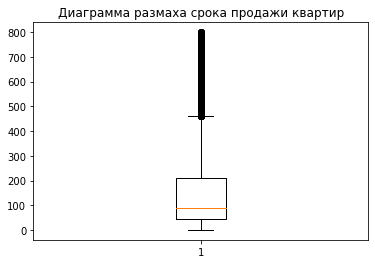

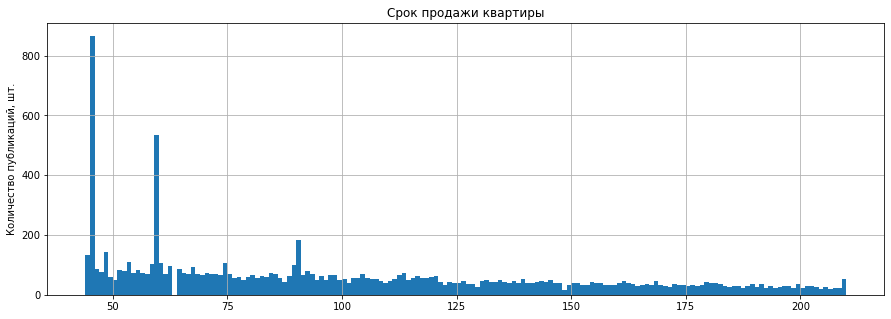

,count,median,mean,std
,days_exposition,days_exposition,days_exposition,days_exposition
year_exposition,,,,
2014,48,594.0,625.875000,67.740313
2015,741,455.0,464.669366,165.137355
2016,2455,210.0,279.386151,208.612279
2017,7687,102.0,157.470405,151.581373
2018,7378,64.0,94.150854,85.037802
2019,1061,23.0,30.775683,23.804087


In [38]:
clear_days_data = data[~data['days_exposition'].isna()]

display(clear_days_data['days_exposition'].describe())
plt.boxplot(clear_days_data['days_exposition'])
plt.title('Диаграмма размаха срока продажи квартир')
plt.show()

clear_days_data['days_exposition'].plot(kind='hist', bins=166, figsize=(15,5), grid=True, title='Срок продажи квартиры',
                                        range=(clear_days_data['days_exposition'].quantile(0.25),
                                               clear_days_data['days_exposition'].quantile(0.75)))
plt.ylabel('Количество публикаций, шт.')
plt.show()

clear_days_data.pivot_table(index='year_exposition', values='days_exposition', aggfunc=['count', 'median', 'mean', 'std'])

### Задание №2

Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы.
  - общей площади;
  - жилой площади;
  - площади кухни;
  - количество комнат;
  - типа этажа, на котором расположена квартира (первый, последний, другой);
  - даты размещения (день недели, месяц, год);

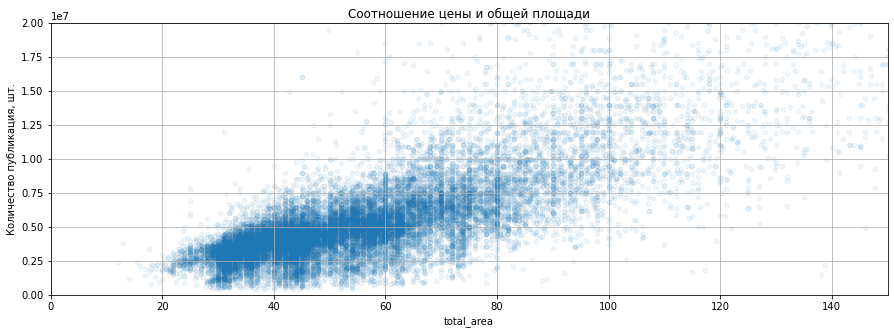

In [39]:
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.07, figsize=(15,5), grid=True, 
          title='Соотношение цены и общей площади')
plt.ylabel('Количество публикация, шт.')
plt.xlim(0, 150)
plt.ylim(0, 20000000);

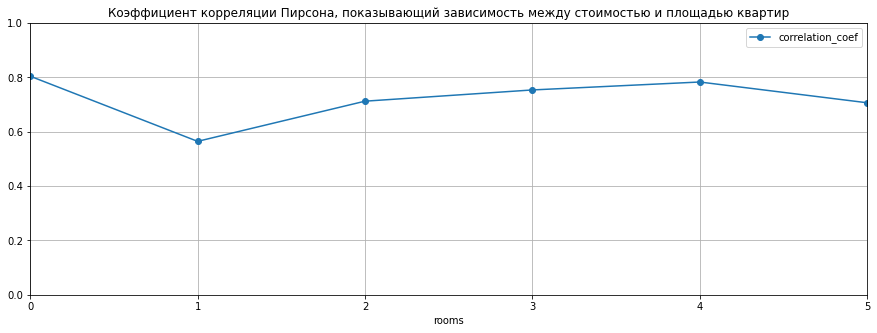

In [40]:
studio      = data.loc[data['rooms']==0, ['rooms', 'last_price', 'total_area']]
one_room    = data.loc[data['rooms']==1, ['rooms', 'last_price', 'total_area']]
two_rooms   = data.loc[data['rooms']==2, ['rooms', 'last_price', 'total_area']]
three_rooms = data.loc[data['rooms']==3, ['rooms', 'last_price', 'total_area']]
four_rooms  = data.loc[data['rooms']==4, ['rooms', 'last_price', 'total_area']]
five_rooms  = data.loc[data['rooms']==5, ['rooms', 'last_price', 'total_area']]

corr_info = []
flat_type = [studio, one_room, two_rooms, three_rooms, four_rooms, five_rooms]
for tp in flat_type:
     corr_info.append([tp['rooms'].unique()[0], tp['total_area'].corr(tp['last_price'])])
corr_table = pd.DataFrame(data=corr_info, columns=['rooms', 'correlation_coef'])

corr_table.plot(x='rooms', y='correlation_coef', style='o-', figsize=(15,5), grid=True)
plt.title('Коэффициент корреляции Пирсона, показывающий зависимость между стоимостью и площадью квартир')
plt.xlim(0, 5)
plt.ylim(0, 1);

На графике просматривается тёмная область в которой сконцентрировано большинство квартир. Эта масса квартир ограничена двумя линиями: максимумом и минимумом стоимости. Максимум имеет форму прямой, и при использовании аппроксимации (округления), можно вывести линейную зависимость. Минимум имеет форму пилы, направленная зубьями вниз. Каждый новый зуб - это появление квартир с бóльшим количеством комнат, но с той же общей площадью. Из-за большого количества квартир одной площади - стоимость проседает.

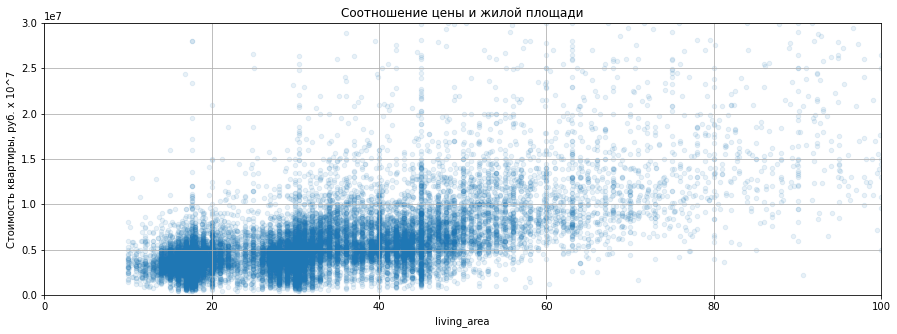

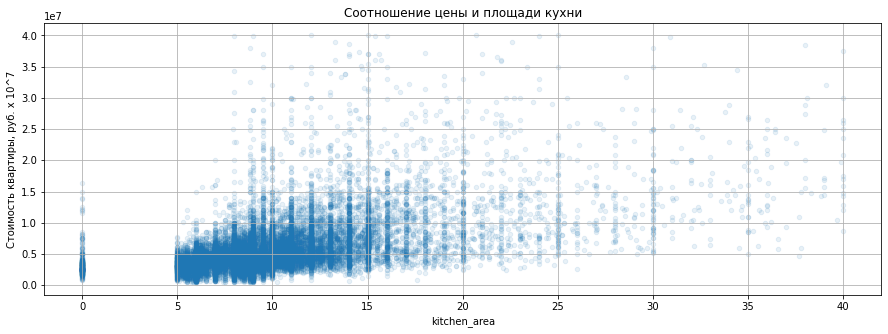

In [41]:
data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.1, figsize=(15,5), grid=True)
plt.title('Соотношение цены и жилой площади')
plt.ylabel('Стоимость квартиры, руб. х 10^7')
plt.xlim(0, 100)
plt.ylim(0, 30000000)
plt.show()

data.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.1, figsize=(15,5), grid=True)
plt.title('Соотношение цены и площади кухни')
plt.ylabel('Стоимость квартиры, руб. х 10^7')
plt.show()

Среди значений _площади кухни_ и _общей площади_, бóльшая зависимость просматривается не от их величины, а от количества однотипных квартир. На графике особо выделяются вертикальны риски - это огромный разброс цен, среди квартир с одинаковыми площадями.

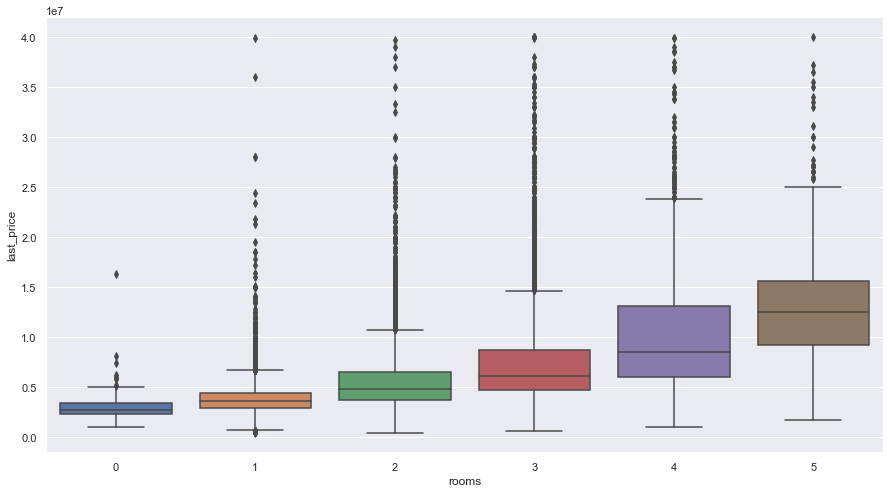

In [42]:
sns.set(rc={'figure.figsize':(15,8)})
sns.boxplot(x='rooms', y='last_price', data=data);

Если соединить медианы, то получится линия схожая с плавно растущей параболой (а точнее только правая её половина). Тоже самую зависимость можно заметить для минимальной цены квартир, только в этом случае центр параболы (её мин. значение) располагается над 2х комнатными квартирами, и от этой точки симметрично начинает расти.

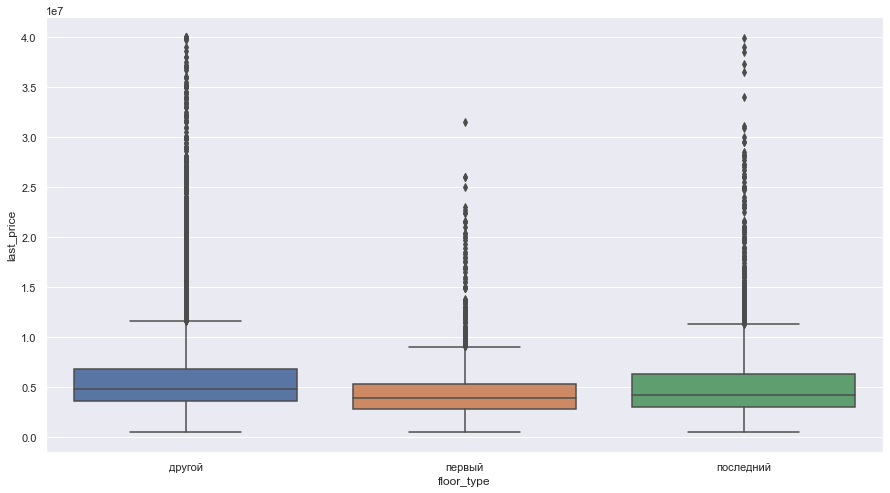

In [43]:
sns.boxplot(x='floor_type', y='last_price', data=data);

Квартиры, расположенные на первом этаже дешевле от рыночной стоимости, в отличие от квартир последнего этажа, которы не так сильно теряют в цене относительно других этажей.

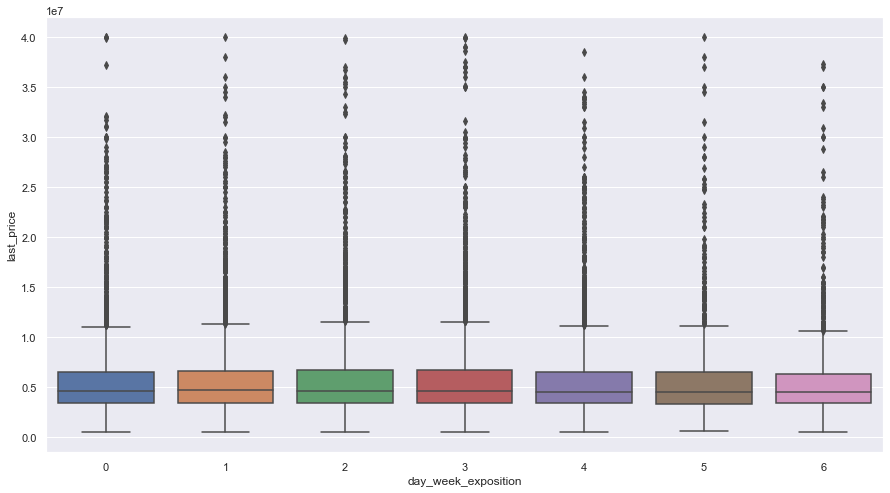

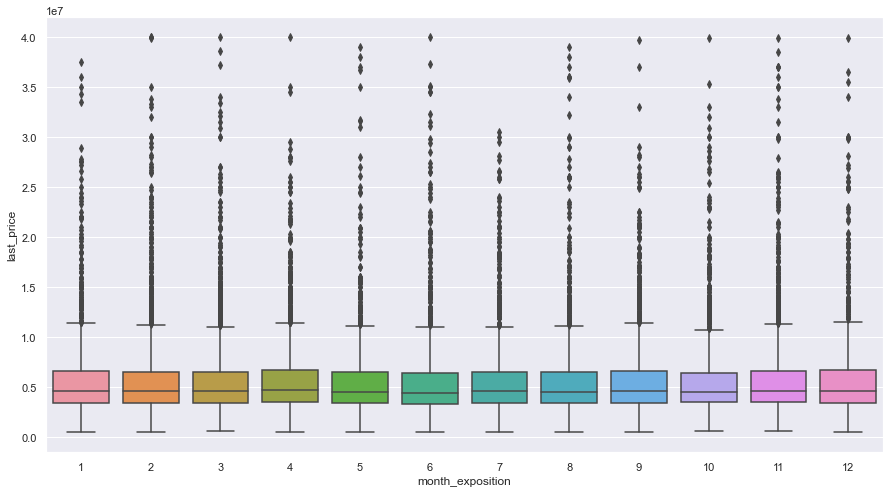

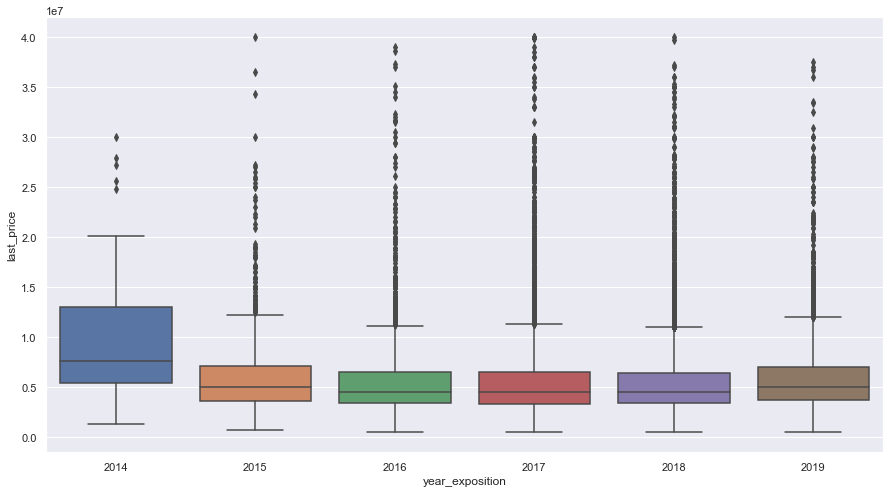

In [44]:
sns.boxplot(x='day_week_exposition', y='last_price', data=data)
plt.show()

sns.boxplot(x='month_exposition', y='last_price', data=data)
plt.show()

sns.boxplot(x='year_exposition', y='last_price', data=data)
plt.show()

Зависимость между стоимостью и _днём_ или _месяцем_ публикации - отсутствует либо крайне мала. Что касается зависимости от _года публикации_, то на графике заметно, что средняя и медианная стоимость квартир уменьшалась в 2015 года. Последующие 3 года имеют крайне схожие значения. Информация за крайние года (2014 и 2019) не полная, по этой причине сделанный по ним вывод, может оказаться неточным или ошибочным.

### Задание №3

Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`.

*`price_meter` - стоимость квадратного метра (значения указаны в рублях)

In [45]:
mean_prise_meter = data[['locality_name', 'price_meter']]

top_10_location = data['locality_name'].value_counts().head(10).to_frame().index
top_10_location_prise_meter = mean_prise_meter[mean_prise_meter['locality_name'].isin(top_10_location)]
top_10_location_prise_meter = (top_10_location_prise_meter
                                   .groupby('locality_name')['price_meter']
                                   .mean()
                                   .astype('int')
                                   .sort_values(ascending=False))

mean_prise_meter = mean_prise_meter.groupby('locality_name')['price_meter'].mean().astype('int')

display('Топ 10 популярных мест:', top_10_location_prise_meter.to_frame())
display('Топ 10 дорогих мест:', mean_prise_meter.head(10).to_frame())
display('Топ 10 дешевых мест:', mean_prise_meter.tail(10).to_frame())

'Топ 10 популярных мест:'

,price_meter
locality_name,
Санкт-Петербург,111247
Пушкин,102812
дер. Кудрово,92441
п. Парголово,90235
Мурино,86027
п. Шушары,78498
Колпино,75275
Гатчина,68891
Всеволожск,68722


'Топ 10 дорогих мест:'

,price_meter
locality_name,
no_name,93075
Бокситогорск,17456
Волосово,39846
Волхов,35042
Всеволожск,68722
Выборг,58475
Высоцк,27397
ГП Большая Ижора,51355
ГП Будогощь,31184


'Топ 10 дешевых мест:'

,price_meter
locality_name,
п. станции Приветнинское,57079
п. станции Свирь,11481
с. Копорье,42008
с. Павлово,61892
с. Паша,28120
с. Путилово,39921
с. Рождествено,37732
с. Русско-Высоцкое,54833
с. Старая Ладога,34696


Величина _стоимости кв. метра_ недвижимости наглядна видна в таблицах. Единственное, что можно добавить это два основных фактора, которые играют максимальную роль: размер населённого пункта (вернее развитая в нём _инфраструктура_), и _расстояние_ до Санкт-Петербурга. Цены округлены для удобства.

### Задание №4

Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.

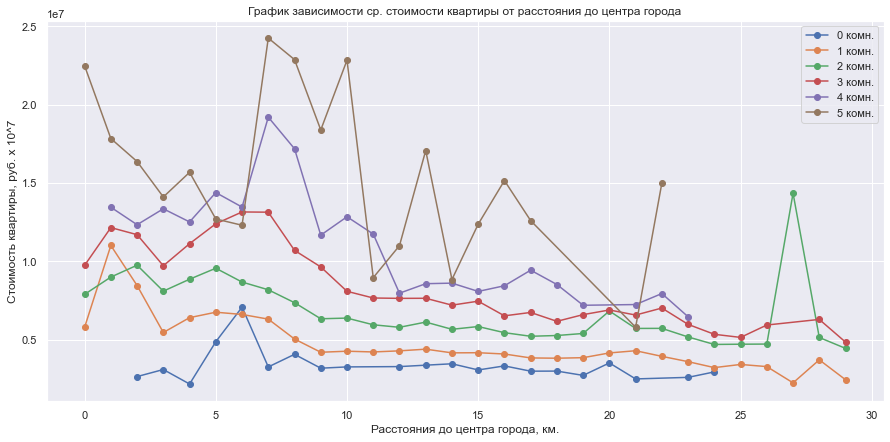

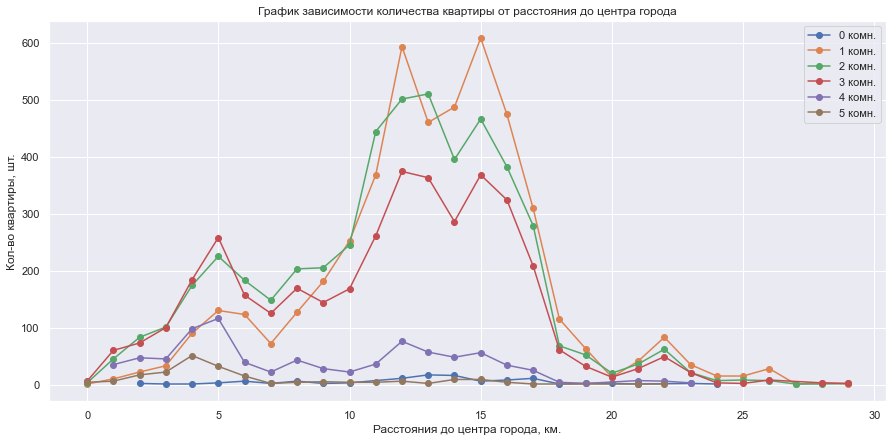

In [46]:
price_per_km = data[['locality_name', 'city_centers_nearest_km', 'last_price', 'rooms']]
price_per_km = price_per_km[price_per_km['locality_name']=='Санкт-Петербург']
price_per_km = price_per_km[price_per_km['city_centers_nearest_km']<=30]


rooms_count = sorted(data['rooms'].unique())
for flat in rooms_count:
    price_per_km.loc[data['rooms']==flat, ['city_centers_nearest_km', 'last_price']]\
        .groupby('city_centers_nearest_km')['last_price'].mean()\
            .plot(style='o-', label=str(flat)+' комн.', legend=True, figsize=(15,7), grid=True)
plt.title('График зависимости ср. стоимости квартиры от расстояния до центра города')
plt.xlabel('Расстояния до центра города, км.')
plt.ylabel('Стоимость квартиры, руб. х 10^7')
plt.show()


rooms_count = sorted(data['rooms'].unique())
for flat in rooms_count:
    price_per_km.loc[data['rooms']==flat, ['city_centers_nearest_km', 'last_price']]\
        .groupby('city_centers_nearest_km')['last_price'].count()\
            .plot(style='o-', label=str(flat)+' комн.', legend=True, figsize=(15,7), grid=True)
plt.title('График зависимости количества квартиры от расстояния до центра города')
plt.xlabel('Расстояния до центра города, км.')
plt.ylabel('Кол-во квартиры, шт.')
plt.show()

График можно выделить несколько смысловых отрезков:
- 0-3км. "Исторический центр" - это единственное, что определяет дороговизну недвижимости. Ввиду плотной застройки, огромного количества общественных мест, и т.п. - могут отсутствовать некоторые удобства: свободная парковка, детские сады, школы.
- 3-7км. "Деловой центр" - районы, которые свободны от туристов, и не так сильно обременены историческим наследством, чтобы иметь свободную возможность к развитию современной городской инфраструктуре. Здесь одно из небольших мест концентрации больших квартир с кол-вом комнат от 4 и более.
- 7-18км "Старые и новые жилые районы" - плавное снижения стоимости квартиры. Некоторые районы могут иметь небольшие отличия между собой в типе жилого фонта, транспортной доступности, что влияет на ср. стоимость. Особая большая концентрация "однушек", "двушек" и "трёшек" на 12ом и 15ом километрах от центра.

Если можно было бы вместе с исходными данными получить пояснение, какая точка принята за "центр города", то можно было бы с хорошей точностью вычислить и локализовать эти жилые районы.

Ещё следует добавить, что 4х и 5ти комнатные квартиры, а так же студии - немногочисленные категории, так что на их стоимость сильно влияет расположение. Квартиры с 1ой, 2мя и 3мя комнатами - очень популярны, их можно найти практически в любом районе, введу этого их стоимость находится в равномерной зависимости от центра (единственное, что на разных участках - разный коэффициент этой зависимости).

In [47]:
display(data[(data['city_centers_nearest_km']==27) & (data['rooms']==2) & (data['locality_name']=='Санкт-Петербург')])

,locality_name,rooms,last_price,price_meter,total_area,living_area,kitchen_area,balcony,ceiling_height,floors_total,...,city_centers_nearest_km,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,first_day_exposition,day_week_exposition,month_exposition,year_exposition
748,Санкт-Петербург,2,14350000,193918,74.0,30.0,25.0,0,3.13,5,...,27.0,1,1496.0,0,0.0,128.0,2017-11-28,1,11,2017


___
<a id='section_5'></a> 
# 5. Общий вывод

Среди всего числа квартир можно выделить в особые группы типовые квартиры (например: старого фонда, новые жилые кварталы). Они имеют большую численность, ряд одинаковых параметров, благодаря чему для них можно построить точную математическую модель ценообразования, которую можно встроить в сайт. Для собственника это даст возможность оценить свою квартиру, а для покупателя понять, является ли цена конкретной квартиры рыночной, или же она завышена/занижена по какой-то причине. Критерии для выборки групп однотипных квартир выведены в исследовании выше.

**Основная зависимость** влияющая на стоимость это: количество схожих по характеристикам квартир. Из **важных характеристик** стоит выделить количество комнат, площади(общая, жилая и кухни), месяц публикации объявления, общее количество этажей в доме, расстояние до центра города в метрах.

Ко второй очереди я бы отнёс: высота потолков; этаж квартиры, в частности тип («первый», «последний», «другой»), балкон,
количество и расстояние до ближайшего аэропорта, парка и водоёма.

На основе проделанной работы, можно сформулировать **ряд недочётов в исходных данных**, и передать их в качестве обратной связи. При последующем обращении это увеличит выборку данных, и сэкономит ресурсы на предобработке. Помимо перечня недочётов, можно передать ряд требований к данным, что так же повысит точность исследования.

Следует уточнить, что алгоритм ценообразования определён для популярных квартир (не больше 5-ти комнат). Большие квартиры - достаточно малочисленные и для них есть возможность выполнить оценку вручную. Если требуется точная стоимость.

В перечень параметров в объявлении стоит добавить год постройки дома. Если он уже есть, то при следующем исследовании стоит выгрузить и эти данные. Это позволит сгруппировывать квартиры по возрасту и точнее обрабатывать пропуски.

**Чек-лист готовности проекта**

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод